In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import numpy as np

%matplotlib notebook
import matplotlib.pyplot as plt

from itertools import chain
from model import Discriminator, Encoder, Generator

#debug use
import pdb

In [2]:
trans = transforms.Compose([transforms.ToTensor(),
                            transforms.Normalize((0.5,), (0.5,))
                           ])

In [5]:
train_set = torchvision.datasets.MNIST(root="../mnist/", train=True, transform=trans, download=True)
test_set = torchvision.datasets.MNIST(root="../mnist/", train=False, transform=trans, download=True)

batch_size = 512

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)

test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)

In [6]:
device = torch.device("cuda:0")

In [7]:
params = {
        "slope": 2e-2,
        "dropout": 0.2,
        "num_channels": 1,
        "z_dim": 128
}

In [8]:
D = Discriminator(params)
G = Generator(params)
E = Encoder(params)

D = nn.DataParallel(D)
G = nn.DataParallel(G)
E = nn.DataParallel(E)

In [9]:
# optimizers
EG_optimzer = optim.Adam(chain(E.parameters(), G.parameters()), 1e-4, betas=(0.5, 0.999), weight_decay=2.5*1e-5)
D_optimzer = optim.Adam(D.parameters(), 1e-4, betas=(0.5, 0.999), weight_decay=2.5*1e-5)

In [10]:
# set iteration to 0
iter_cnt = 0
EPS = 1e-12

In [33]:
D.to(device)
G.to(device)
E.to(device)

D.train()
G.train()
E.train()

for epoch in range(10):
        for batch_idx, (batch_x, _) in enumerate(train_loader):
            
            batch_x = batch_x.to(device)
            
            # real loss
            e = E(batch_x)
            D_real_out = D(batch_x, e).squeeze()
            
            # fake loss with noise
            z = torch.randn(batch_x.shape[0], 128, 1, 1).to(device)
            G_out = G(z)
            D_fake_out = D(G_out, z).squeeze()
            
            D_loss = -torch.mean(torch.log(D_real_out + EPS) + torch.log(1 - D_fake_out + EPS))
            EG_loss = -torch.mean(torch.log(D_fake_out + EPS) + torch.log(1 - D_real_out + EPS))
            
            D_optimzer.zero_grad()
            D_loss.backward(retain_graph=True)
            D_optimzer.step()
            
            EG_optimzer.zero_grad()
            EG_loss.backward()
            EG_optimzer.step()
            
            if iter_cnt % 100 == 0:
                print("Iter ", iter_cnt, " D_Loss ", D_loss.item(), " EG_Loss ", EG_loss.item())
            
            iter_cnt += 1

Iter  3600  D_Loss  0.5342792868614197  EG_Loss  5.200610637664795
Iter  3700  D_Loss  0.6654671430587769  EG_Loss  5.243900299072266
Iter  3800  D_Loss  0.5412226915359497  EG_Loss  5.337978839874268
Iter  3900  D_Loss  0.8818719983100891  EG_Loss  5.3688764572143555
Iter  4000  D_Loss  0.6326400637626648  EG_Loss  4.8455634117126465
Iter  4100  D_Loss  0.5767801403999329  EG_Loss  5.510530471801758
Iter  4200  D_Loss  0.6088132262229919  EG_Loss  5.046708106994629
Iter  4300  D_Loss  0.5867125988006592  EG_Loss  5.260931491851807
Iter  4400  D_Loss  0.6660727262496948  EG_Loss  4.885455131530762
Iter  4500  D_Loss  0.4682145118713379  EG_Loss  5.659124374389648
Iter  4600  D_Loss  0.6870763897895813  EG_Loss  5.4222588539123535
Iter  4700  D_Loss  0.4974459409713745  EG_Loss  5.457386016845703


In [43]:
torch.save({'D': D.state_dict(),
            'G': G.state_dict(),
            'E': E.state_dict()
           }, "./saves")

In [34]:
G.eval()
E.eval()
test_G = G.module
test_E = E.module

<IPython.core.display.Javascript object>


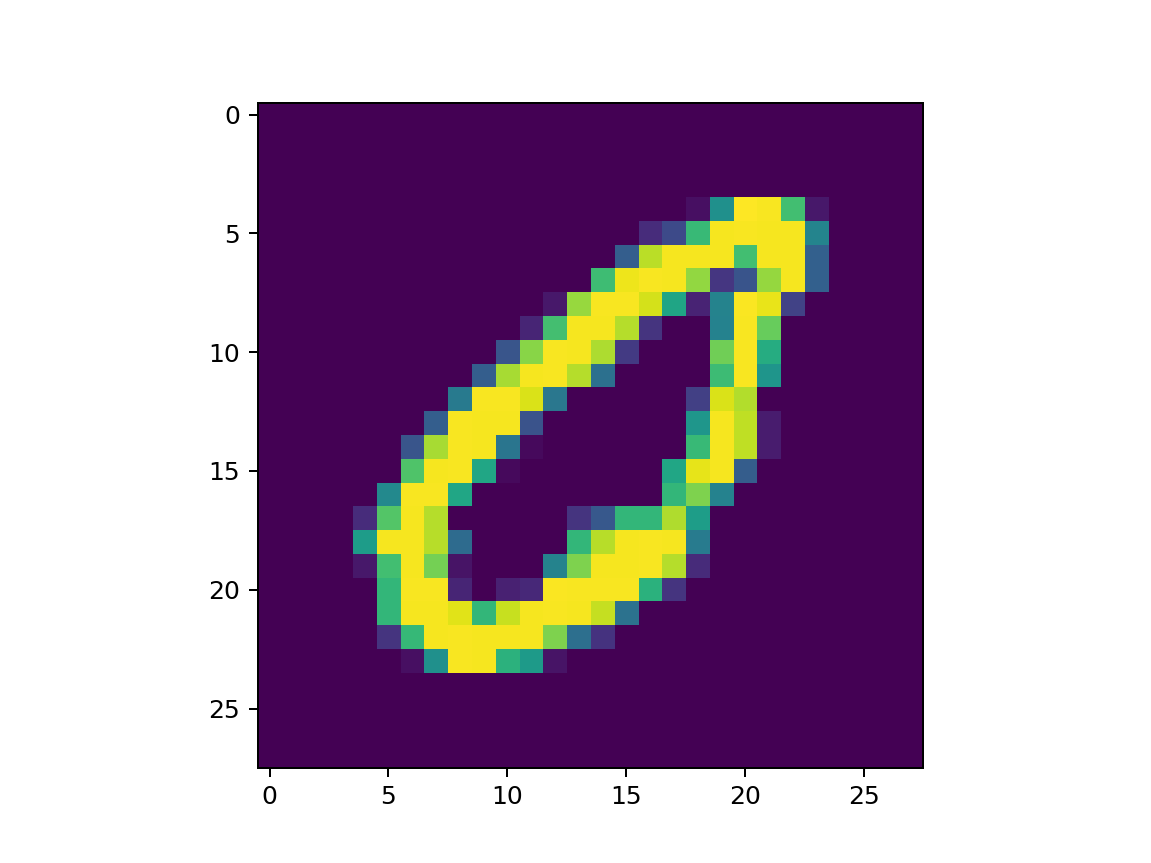

In [41]:
real = batch_x[60].detach().unsqueeze(0)
plt.imshow(real.cpu().squeeze().numpy())

<IPython.core.display.Javascript object>


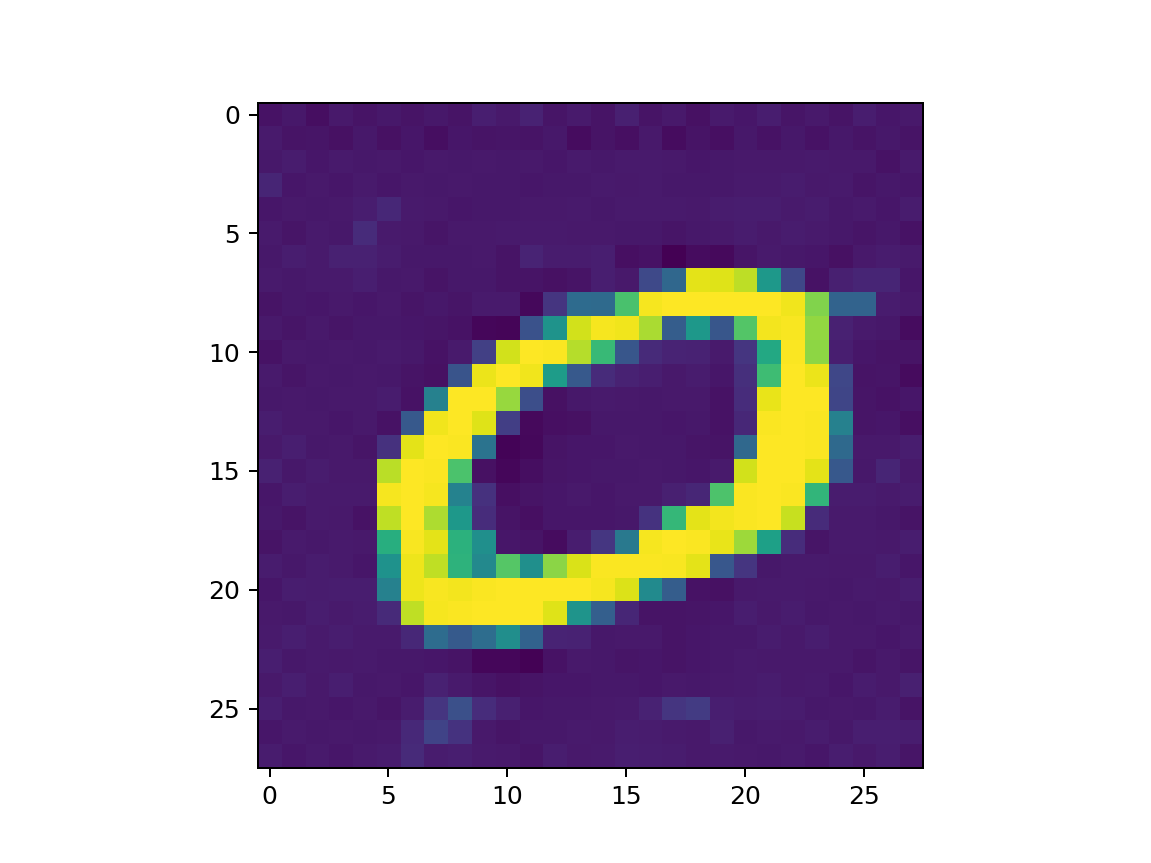

In [42]:
z = test_E(real)
image = test_G(z)Iter  4100  D_Loss  0.5767801403999329  EG_Loss  5.510530471801758

plt.imshow(image.detach().cpu().squeeze().numpy())

In [ ]:
noise = torch.randn(10, 128, 1, 1)
images = test_net(noise)
plt.imshow(images[0].squeeze().detach().numpy())